# JPEG COMPRESSION ALGORITHM

### THÀNH VIÊN NHÓM
|MSSV|HỌ VÀ TÊN|
|---|---|
|19127003|NGUYỄN HỮU ĐẠT|
|19127472|NGUYỄN BÁ MINH|
|19127481|TRẦN HOÀNG NAM|
|19127595|NGUYỄN MINH TRÍ|


### GIỚI THIỆU ĐỒ ÁN
- File JPEG (hay File Joint Photographic Experts Group) là một loại định dạng hình ảnh được lưu bằng phương pháp lossy compression (nén có mất mát dữ liệu).Trong đó, hình ảnh đầu ra là kết quả của quá trình nén, là sự cân bằng giữa kích thước lưu trữ và chất lượng hình ảnh. Hơn [70% website](https://w3techs.com/technologies/details/im-jpeg) trên thế giới sử dụng ảnh có định dạng JPEG để lưu trữ
- Smartphone và camera sử dụng JPEG để lưu trữ
- Thuật toán nén video h.264 được sử dụng trên youtube sử dụng kỹ thuật nén tương tự JPEG
- Các thuật toán nén như JPEG giúp giảm thiểu chi phí lưu trữ, cũng như giảm thời gian khi gửi qua internet

Phía dưới là một pipeline của thuật toán nén JPEG Compression

  <img src="https://raw.githubusercontent.com/minhtri6179/tinyJPEG/main/images/pipeline.png"
     width="800"
     height="500" />

#### Mục tiêu của đồ án:
- Hiểu được cách hoạt động của thuật toán JPEG compression tuần tự: 50%
- Củng cố lại kiến thức về song song hoá trên GPU thông qua việc tối ưu hoá thuật toán bằng xử lý song song : 50%
  - Color transform: 10%
  - Down sampling: 10%
  - Forward DCT: 10%
  - Quantization: 10%
  - Encoding và compressed data: 10%

#### Các thách thức
- Học cách song song hoá bằng ngôn ngữ python
- Kiến thức mới về Discrete cosin transform (DCT),Quantization, mã hoá huffman
- Một vài bước trong thuật toán không thể song song hoàn toàn mà là song song một cách tuần tự

In [1]:
import numpy as np
import numba as nb
from numba import jit,prange,cuda
from PIL import Image
import cv2
import math

In [2]:
devices = nb.cuda.list_devices()
for device in devices:
        print("Thiết bị GPU có ID:", device.id)

Thiết bị GPU có ID: 0


In [3]:
selected_device = 0
nb.cuda.select_device(selected_device)

<weakproxy at 0x7d9dde71c220 to Device at 0x7d9dde710dc0>

# NỘI DUNG

##### LOAD ẢNH

In [4]:
%%capture
! wget https://github.com/minhtri6179/tinyJPEG/raw/main/input_image/img.bmp

In [5]:
img = Image.open('img.bmp')
arr = np.array(img)
(height, width, _) = arr.shape
print(height,width)

3456 5184


In [6]:
def row_column_padding(image):
    height, width,RGB = image.shape

    # Tính toán kích thước ma trận mới sau padding
    padded_height = int(np.ceil(height / 8)) * 8
    padded_width = int(np.ceil(width / 8)) * 8

    # Tạo ma trận mới với kích thước sau padding và gán giá trị từ ma trận ban đầu
    padded_image = np.zeros((padded_height, padded_width,RGB))
    padded_image[:height, :width,:] = image
    padded_image[height:, :,:] = padded_image[height-1:height, :,:]
    padded_image[:, width:,:] = padded_image[:, width-1:width,:]

    return padded_image

In [7]:
def row_column_padding_matrix(image):
    height, width = image.shape

    # Tính toán kích thước ma trận mới sau padding
    padded_height = int(np.ceil(height / 8)) * 8
    padded_width = int(np.ceil(width / 8)) * 8

    # Tạo ma trận mới với kích thước sau padding và gán giá trị từ ma trận ban đầu
    padded_image = np.zeros((padded_height, padded_width))
    padded_image[:height, :width] = image
    padded_image[height:, :] = padded_image[height-1:height, :]
    padded_image[:, width:] = padded_image[:, width-1:width]

    return padded_image

In [8]:
arr = row_column_padding(arr)
(height, width, _) = arr.shape

#### CHUYỂN TỪ KÊNH MÀU RGB SANG KÊNH MÀU *YCbCr*
Để chuyển từ màu RGB sang YUV, chúng ta sẽ thực hiện theo công thức sau

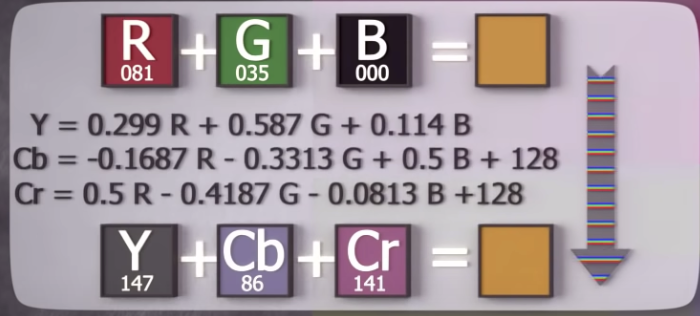

In [9]:
def convert_rgb_to_YCbCr(matrix):
  R = np.zeros((height, width), np.float32) + matrix[:, :, 0]
  G = np.zeros((height, width), np.float32) + matrix[:, :, 1]
  B = np.zeros((height, width), np.float32) + matrix[:, :, 2]
  Y = 0.299 * R + 0.587 * G + 0.114 * B
  Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
  Cr = 0.5 * R - 0.4187 * G - 0.0813 * B +128
  return Y, Cb, Cr

In [10]:
import math
import numba as nb
import numpy as np

@cuda.jit
def convert_rgb_to_YCbCr_kernel(matrix,d_Y,d_Cb,d_Cr,size):
  # Thread index in a 2D block
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  # Block index in a 2D grid
  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y
  # Block width
  bw = cuda.blockDim.x
  bh = cuda.blockDim.y

  # row and col
  col = tx + bx * bw
  row = ty + by * bh

  if row < size[0] and col < size[1]:
    R = matrix[row,col,0]
    G = matrix[row,col,1]
    B = matrix[row,col,2]

    d_Y[row,col] = 0.299 * R + 0.587 * G + 0.114 * B
    d_Cb[row,col] = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
    d_Cr[row,col] = 0.5 * R - 0.4187 * G - 0.0813 * B +128

def convert_rgb_to_YCbCr_GPU(matrix):
  d_matrix = nb.cuda.to_device(matrix)

  size = nb.cuda.to_device(matrix.shape)
  d_Y = cuda.device_array(matrix.shape[:2])
  d_Cb = cuda.device_array(matrix.shape[:2])
  d_Cr = cuda.device_array(matrix.shape[:2])

  threadsperblock = (32, 32)
  blockspergrid_x = math.ceil(matrix.shape[1] / threadsperblock[1])
  blockspergrid_y = math.ceil(matrix.shape[0]/ threadsperblock[0])
  blockspergrid = (blockspergrid_x, blockspergrid_y)
  convert_rgb_to_YCbCr_kernel[blockspergrid, threadsperblock](d_matrix, d_Y, d_Cb, d_Cr,size)

  # Copy kết quả từ GPU sang CPU
  Y = d_Y.copy_to_host()
  Cb = d_Cb.copy_to_host()
  Cr = d_Cr.copy_to_host()
  return Y,Cb,Cr

In [11]:
Y, Cb, Cr = convert_rgb_to_YCbCr(arr)
Y_, Cb_, Cr_ = convert_rgb_to_YCbCr_GPU(arr)

In [12]:
np.testing.assert_allclose(Y_, Y, atol=0.00001)
np.testing.assert_allclose(Cb_, Cb, atol=0.00001)
np.testing.assert_allclose(Cr_, Cr, atol=0.00001)

In [13]:
%timeit -n 10 Y, Cb, Cr = convert_rgb_to_YCbCr(arr)

851 ms ± 128 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit -n 10 Y, Cb, Cr = convert_rgb_to_YCbCr_GPU(arr)

273 ms ± 8.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Thời gian thực hiện trên CPU: ~851 ms
- Thời gian thực hiện trên GPU: ~273 ms
- Nhận xét: Thời gian thực hiện trên GPU giảm được 50% so với CPU

Quan sát các bức ảnh ở trên, chúng ta thấy rằng các chi tiết Chrominance rất khó để nhận biết, vì vậy, ở bước tiếp theo, chúng ta sẽ giảm kích thước của kênh màu Chrominance blue và red, bằng cách gộp 4 ô thành 1 block, giá trị của block này là giá trị trung bình của 4 ô trong block

#### GIẢM KÍCH THƯỚC KÊNH MÀU CHROMINANCE

In [15]:
@jit
def down_sampling_chrominance(matrix):
  height, width = matrix.shape
  new_height = int(height/2)
  new_width = int(width /2)
  result = np.zeros((new_height,new_width), np.float32)
  for i in range(0,new_height):
    for j in range(0,new_width):
      result[i,j] = np.mean(matrix[i*2:i*2+2,j*2:j*2+2])
  return result
def down_sampling_CPU(Cb,Cr):
  newCb = down_sampling_chrominance(Cb)
  newCr = down_sampling_chrominance(Cr)
  return newCb,newCr

In [16]:
@nb.cuda.jit
def down_sampling_chrominance_kernel(chrominance,size,result):
  # Thread index in a 2D block
  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  # Block index in a 2D grid
  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y
  # Block width
  bw = cuda.blockDim.x
  bh = cuda.blockDim.y

  # row and col
  col = tx + bx * bw
  row = ty + by * bh


  if row < size[0] and col < size[1]:
        result[row, col] = (chrominance[2 * row, 2 * col] +
                               chrominance[2 * row + 1, 2 * col] +
                               chrominance[2 * row, 2 * col + 1] +
                               chrominance[2 * row + 1, 2 * col + 1]) / 4.0

def down_sampling_chrominance_gpu(chrominance):
    # Kích thước mới của ma trận chrominance sau down sampling
    d_chrominance = nb.cuda.to_device(chrominance)
    new_height = chrominance.shape[0] // 2
    new_width = chrominance.shape[1] // 2

    # Khởi tạo mảng kết quả trên GPU
    size = nb.cuda.to_device([new_height,new_width])
    d_result = nb.cuda.device_array((new_height, new_width))

    # Thực hiện down sampling trên GPU
    threadsperblock = (32, 32)
    blockspergrid_x = math.ceil(chrominance.shape[1] / threadsperblock[1])
    blockspergrid_y = math.ceil(chrominance.shape[0]/ threadsperblock[0])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    down_sampling_chrominance_kernel[blockspergrid, threadsperblock](d_chrominance,size, d_result)

    # Copy kết quả từ GPU về CPU
    result = d_result.copy_to_host()
    return result

In [17]:
def down_sampling_GPU(Cb,Cr):
  newCb = down_sampling_chrominance_gpu(Cb)
  newCr = down_sampling_chrominance_gpu(Cr)
  return newCb,newCr

In [18]:
newCb,newCr = down_sampling_CPU(Cb,Cr)
newCb_,newCr_ = down_sampling_GPU(Cb,Cr)

In [19]:
np.testing.assert_almost_equal(newCr_,newCr,decimal=5)
np.testing.assert_almost_equal(newCb_,newCb,decimal=5)

- Ở đây, chúng ta giảm kích thước của 2 kênh màu là newCb, newCr chỉ còn kích thước bằng 1/4 so với Cb,Cr
- Trước khi giảm Y + Cb + Cr = 1 + 1 + 1 = 3
- Sau khi giảm Y + newCb + newCr = 1 + 1/4 + 1/4 = 1.5
Vậy chúng ta đã giảm được 50% kích thước ảnh so với ban đầu

In [20]:
%timeit down_sampling_CPU(Cb,Cr)

244 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit down_sampling_GPU(Cb,Cr)

105 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Thời gian thực hiện trên CPU: ~244 ms
- Thời gian thực hiện trên GPU: ~105 ms
- Nhận xét: Thời gian thực hiện trên GPU giảm được 50% so với CPU

#### DISCRETE COSINE TRANSFORM

#### QUANTIZATION

## ZIGZAG SCANNING

## RUN LENGTH ENCODING

## HUFFMAN ENCODING

# THAM KHẢO